In [1]:
import pandas as pd
import numpy as np
from astroquery.mast import Catalogs
from astroquery.mast import Observations
import matplotlib.pyplot as plt

from astropy.io.votable import parse
import pandas as pd

In [3]:
import dustmaps.leike_ensslin_2019
dustmaps.leike_ensslin_2019.fetch(clobber=True)

Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.


In [8]:
df = pd.read_csv('../tic_query.csv')

In [9]:
df['a_g']

,Unnamed: 0,ID,version,HIP,TYC,UCAC,TWOMASS,SDSS,ALLWISE,GAIA,...,splists,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,objID
0,0,102209796,20190415,NaN,NaN,490-016271,05555642+0756359,NaN,J055556.41+075634.1,3.323018e+18,...,cooldwarfs_v8,1.557872,1.303832,88.985041,7.942615,0.056317,0.062824,1.0,0,92275922
1,1,102285623,20190415,NaN,NaN,NaN,05565148+1143426,NaN,J055651.51+114343.2,3.342959e+18,...,cooldwarfs_v8,2.097398,2.085312,89.214693,11.728708,0.065598,0.063427,1.0,0,93967389
2,2,102542088,20190415,NaN,0720-00944-1,501-017939,05582235+1008295,NaN,J055822.35+100829.1,3.341749e+18,...,NaN,1.320054,1.086667,89.593184,10.141386,0.049744,0.046989,0.0,0,93970021
3,3,102286828,20190415,NaN,NaN,509-016605,05565722+1144333,NaN,NaN,3.342958e+18,...,cooldwarfs_v8,2.731550,2.239705,89.240772,11.741070,0.091704,0.090924,1.0,0,94073712
4,4,102451402,20190415,NaN,NaN,489-016083,05581281+0745449,NaN,J055812.82+074544.5,3.323184e+18,...,cooldwarfs_v8,1.066116,1.054176,89.553478,7.762336,0.031445,0.030097,1.0,0,94075676
5,5,102539681,20190415,NaN,NaN,498-018476,05583507+0927532,NaN,J055835.06+092753.8,3.335661e+18,...,cooldwarfs_v8,2.131726,1.700073,89.646102,9.465044,0.072300,0.063756,1.0,0,94076222
6,6,102211030,20190415,NaN,NaN,485-015253,05561522+0655541,NaN,J055615.21+065553.3,3.322697e+18,...,cooldwarfs_v8,31.057003,31.000186,89.063389,6.931404,0.108063,0.107347,1.0,0,94179293
7,7,102281507,20190415,28110.0,0720-01925-1,498-017993,05562803+0930337,NaN,J055628.03+093033.8,3.335699e+18,...,NaN,2.717387,2.270188,89.116810,9.509332,0.092837,0.086646,0.0,0,94179727
8,8,102328798,20190415,NaN,NaN,NaN,05572967+0700108,NaN,J055729.64+070010.4,3.322700e+18,...,cooldwarfs_v8,1.588848,1.395135,89.373497,7.002832,0.050146,0.048135,1.0,0,94180797
9,9,102403607,20190415,NaN,NaN,492-016739,05574636+0821009,NaN,J055746.32+082100.0,3.323430e+18,...,cooldwarfs_v8,0.773910,0.654905,89.442973,8.349917,0.026069,0.024636,1.0,0,94181000


In [39]:
import scipy.integrate as integrate
from scipy.stats import norm

def ud_distpost3(r,w,wsd,rlen):
    ud = d_like(w, r, wsd)*np.exp(-r/rlen)*(r**2)
    return ud

# Normalized Gaussian likelihood in w. Vectorized in any one parameter.
def d_like(w,r,wsd):
    return norm.pdf(w, 1/r, wsd)

def get_distance_posterior(plx, plx_err, rlen, r_est, N=100000):
    # DISTANCE CALCULATION
    w = (plx)*0.001
    wsd = (plx_err)*0.001
    
    if r_est < 1000:
        scale = 0.01
    else:
        scale = 10
    
    rlo, rhi = r_est-scale*rlen, r_est+scale*rlen
    if rlo < 0:
        rlo = 1e-10
    rplot = np.linspace(rlo,rhi,N)
    dprior = (1/(2*rlen**3))*np.exp(-rplot/rlen)*rplot**2
    dpost  = ud_distpost3(rplot, w, wsd, rlen)
    
    integ = integrate.quad(ud_distpost3, rlo, rhi, args=(w,wsd,rlen))
    dpost_norm = dpost/integ[0]
    
    rlo, rhi = rplot[dpost_norm > 1e-20][0], rplot[dpost_norm > 1e-20][-1]
    rplot = np.linspace(rlo,rhi,N)
    dprior = (1/(2*rlen**3))*np.exp(-rplot/rlen)*rplot**2
    dpost  = ud_distpost3(rplot, w, wsd, rlen)
    integ = integrate.quad(ud_distpost3, rlo, rhi, args=(w,wsd,rlen))
    dpost_norm = dpost/integ[0]
#     distance = rplot[np.argmax(dpost_norm)]

    values = dpost_norm
    arr2 = (values - values.min()) / (values.max() - values.min())
    arr2 /= arr2.sum()
    posterior_norm = np.random.choice(rplot,size=N, p=arr2)
    
    return posterior_norm

In [5]:
from astropy.coordinates import SkyCoord
from dustmaps.bayestar import BayestarQuery
from dustmaps.leike_ensslin_2019 import LeikeEnsslin2019Query
from astropy import units

leike = LeikeEnsslin2019Query()

def get_extinction_posterior(ra, dec, distance_posterior):
    coords = SkyCoord(ra=ra*units.deg, dec=dec*units.deg,
                          distance=distance_posterior*units.pc)
    reddening = leike(coords)

    if np.any(np.isnan(reddening)):
        return np.zeros(len(distance_posterior))
    
    return reddening

In [6]:
from scipy.interpolate import RegularGridInterpolator
import h5py

bcmodel = h5py.File('bcgrid.h5', 'r')
interp = RegularGridInterpolator((np.array(bcmodel['teffgrid']), \
        np.array(bcmodel['logggrid']),np.array(bcmodel['fehgrid']), \
            np.array(bcmodel['avgrid'])),np.array(bcmodel['bc_ga'])) 

def getbc_posterior(teff, logg=4., feh=0.,N=100000):
    try:
        bc = interp(np.array([teff,logg,feh,0]))[0]
    except:
        bc = 0.
    return np.random.normal(bc, 0.04, N)

In [50]:
from tqdm import tqdm

def getbc(teff,logg,feh,av):
    return interp(np.array([teff,logg,feh,av]))[0]

def log_L_bol(mag, distance, extinction, BC):
    return (-((mag - 5*(np.log10(distance)-1) - extinction) + BC - 4.74)/2.5)

N = 50000
values = []
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    distance = get_distance_posterior(row['plx'], row['e_plx'], row['r_len'], row['r_est'], N=N)
    
    if np.isnan(row['a_g_val']):
        extinction = get_extinction_posterior(row['ra'], row['dec'], distance)
    else:
        sigma = 0.5*(row['a_g_percentile_upper']+row['a_g_percentile_lower'])
        extinction = np.random.normal(row['a_g_val'], sigma, N)
        
    logg = row['logg']
    if np.isnan(logg):
        logg = 4.
        
    feh = row['mh']
    if np.isnan(feh):
        feh = 4.
    bc = getbc_posterior(row['teff_val'], logg=logg, feh=feh, N=N)
    mag = np.random.normal(row['gaiamag'], row['e_gaiamag'], N)
    
    val = log_L_bol(mag, distance, extinction, bc)
    
    values.append([np.mean(val), np.median(val), np.percentile(val,84.13), np.percentile(val,15.86), np.std(val), np.median(bc)])

100%|██████████| 668/668 [01:22<00:00,  8.60it/s]


In [51]:
values = np.array(values)
df['mc_lum'] = values[:,0]
df['mc_lum_sd'] = values[:,4]
df['mc_bc'] = values[:,5]

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [55]:
import matplotlib

from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 300

red = '#e41a1c'
blue = '#377eb8'
green = '#4daf4a'
purple = '#984ea3'
orange = '#ff7f00'

overleaf_path = '/Users/danielhey/Dropbox (Sydney Uni)/Apps/Overleaf/pm_planet_mass/figs/'
matplotlib.rcParams["font.size"] = 7.
matplotlib.rcParams['font.family'] = 'Arial'
#plt.rc('font', family='serif')
matplotlib.rcParams['xtick.labelsize'] = 7
matplotlib.rcParams['ytick.labelsize'] = 7

def mnras_size(fig_width_pt, square=False):
    inches_per_pt = 1.0/72.00              # Convert pt to inches
    golden_mean = (np.sqrt(5)-1.0)/2.0     # Most aesthetic ratio
    fig_width = fig_width_pt*inches_per_pt # Figure width in inches
    if square:
        fig_height = fig_width
    else:
        fig_height = fig_width*golden_mean
    return [fig_width,fig_height]

In [56]:
df.to_csv('bonus_stars_huber.csv')

In [57]:
df_roap = pd.read_csv('roap_lum_final.csv')
df_dsct = pd.read_csv('dsct_lum_final.csv')
df_huber = pd.read_csv('bonus_stars_huber.csv')

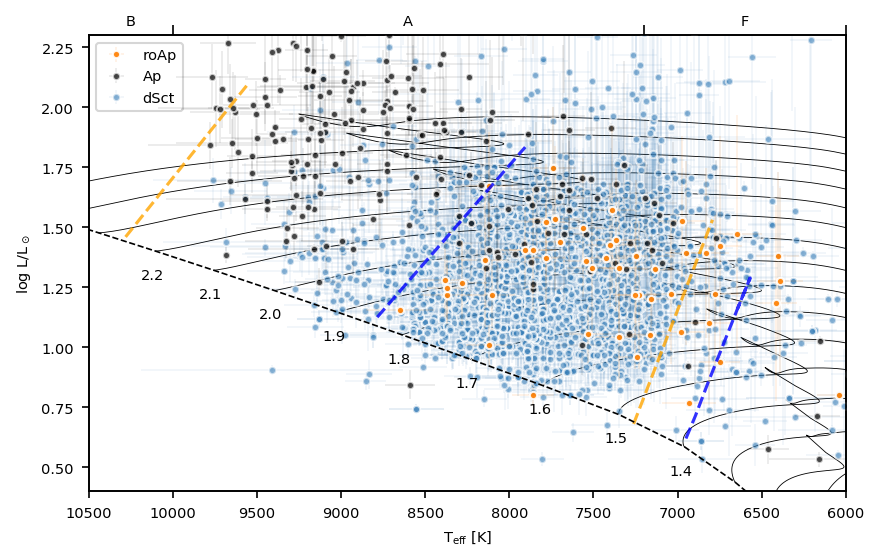

In [63]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

# And now the new ones
Lcolnames = ["T11", "L11", "G11", "T12", "L12", "G12", "T13", "L13", "G13", "T14", "L14", "G14", "T15", "L15", "G15", "T16", "L16", "G16", "T17", "L17", "G17", "T18", "L18", "G18", "T19", "L19", "G19", "T20", "L20", "G20", "T21", "L21", "G21", "T22", "L22", "G22", "T23", "L23", "G23", "T24", "L24", "G24", "T25", "L25", "G25"]
Ltracks = pd.read_csv("../Shared/instability_strip/mesa10108_as09_opal_exp150_mlt180_D000_z140x071_orig.csv",  header=None, sep=" ", names=Lcolnames, skiprows=([0]))
msL = pd.DataFrame(data={"Tms": Ltracks.loc[0][0::3].values, "Lms": Ltracks.loc[0][1::3].values, "Gms": Ltracks.loc[0][2::3].values})

fig, axes = plt.subplots(figsize=mnras_size(469))

roaps = df_roap['comments'] == "b'roAp'"
axes.errorbar(df_roap[roaps]['teff_val'], df_roap[roaps]['mc_lum'], fmt='.',xerr=df_roap[roaps]['e_teff'], alpha=0.9,
              yerr=df_roap[roaps]['mc_lum_sd'].values, markeredgecolor='white',  c=orange, elinewidth=0.1, markersize=7, zorder=30, label='roAp', rasterized=True)
axes.errorbar(df_roap[~roaps]['teff_val'], df_roap[~roaps]['mc_lum'], fmt='.',xerr=df_roap[~roaps]['e_teff'], 
              yerr=df_roap[~roaps]['mc_lum_sd'].values,  markeredgecolor='white',  c='black', alpha=0.7, elinewidth=0.1, markersize=7, zorder=29, label='Ap', rasterized=True)

axes.errorbar(df_dsct['teff_val'], df_dsct['mc_lum'], fmt='.',xerr=df_dsct['e_teff'], alpha=0.6,
              yerr=df_dsct['mc_lum_sd'].values,  markeredgecolor='white', c=blue, elinewidth=0.1, markersize=7, zorder=9, label='dSct', rasterized=True)

# axes.errorbar(df_huber['teff_val'], df_huber['mc_lum'], fmt='.',xerr=df_huber['e_teff'], alpha=0.6,
#               yerr=df_huber['mc_lum_sd'].values,  markeredgecolor='white', c=green, elinewidth=0.1, markersize=7, zorder=900, label='dSct', rasterized=True)



for n, mass in zip(np.arange(0,len(Lcolnames)/3), np.arange(1.1,4,0.1)):
    axes.plot(Ltracks.iloc[:,int(3*n+0)],Ltracks.iloc[:,int(3*n+1)],c='black',linewidth=0.4, zorder=0)
    max_mass = 2.3
    if (mass > 1.4) & (mass < max_mass):
        axes.text(Ltracks.iloc[:,int(3*n+0)][0]+20, Ltracks.iloc[:,int(3*n+1)][0]-0.1, str(np.round(mass,2)), c='black',horizontalalignment='center',verticalalignment='center', zorder=100)
axes.plot(msL['Tms'], msL['Lms'], c='black', linewidth=0.8, linestyle='dashed', zorder=101)

axes.set_xlim(10500,6000)
axes.set_xlabel(r'T$_{\rm eff}$ [K]')
axes.set_ylabel(r'log L/L$_\odot$')
axes.set_ylim(0.4,2.3)
plt.legend()




# Roap instability
x1=np.array([4.0120,3.9805])
y1=(1.5-1.7)*(x1-4.0)/(4.01-4.0)+1.7
# x2=np.array([3.861, 3.842])
x2=np.array([3.861, 3.832])
y2=(1.15-0.71)*(x2-3.86)/(3.845-3.86)+0.71

plt.plot(10**x1,y1, c='orange', linestyle='dashed', zorder=100, alpha=0.8)
plt.plot(10**x2, y2, c='orange', linestyle='dashed', zorder=100, alpha=0.8)

# https://en.wikipedia.org/wiki/Stellar_classification#Harvard_spectral_classification
colors = np.array([
    [146,181,255],
    [162,192,255],
    [213,224,255],
    [249,245,255],
    [255,237,227],
    [255,218,181],
    [255,181,108]
]) / 255

classes = np.array([
    [30000, 50000],
    [10000,10500],
    [7200,10000],
    [6000,7200],
    [5200,6000],
    [3700,5200],
    [3000,3700]
])

# for color, sptype in zip(colors, classes):
#     axes.axvspan(sptype[0], sptype[1], color=color, zorder=1, alpha=0.5)
    
ax = axes
ax2 = ax.twiny()
ax2.set_xlim(10500,6000)


# Major ticks
ticks2 = [3700,5200,6000,7200,10000]
ax2.set_xticks(ticks2)
ax2.set_xticklabels([])
ax2.tick_params(axis='x', which="major", length=5)
ax2.set_xlim(10500,6000)

# Minor ticks
ticks1 = np.average(classes, axis=1)
labs = ['O', 'B', 'A', 'F', 'G', 'K', 'M']
ax2.set_xticks(ticks1, minor=True)
ax2.set_xticklabels(labs, minor=True)
ax2.tick_params(axis='x', which="minor",length=0)
ax2.set_xlim(10500,6000)


Linsta_cols = ["dsctbT", "dsctbL", "dsctbG", "dsctrT", "dsctrL", "dsctrG", "gdorbT", "gdorbL", "gdorbG", "gdorrT", "gdorrL", "gdorrG"]
Linsta = pd.read_csv("instability_strips_logL.txt", header=None, sep="\t", names=Linsta_cols)


ax.plot(Linsta["dsctbT"],Linsta["dsctbL"],c='blue', linestyle='dashed', zorder=100, alpha=0.8)
ax.plot(Linsta["dsctrT"],Linsta["dsctrL"],c='blue', linestyle='dashed', zorder=100, alpha=0.8)

# ax.plot([7500,6500],[0.75,1.65],c='blue', linestyle='dashed', zorder=100, alpha=0.8)
# ax.plot([9400,8550],[1.25,2.20],c='blue', linestyle='dashed', zorder=100, alpha=0.8)
plt.savefig('roap_dsct_HRD_v3.pdf', dpi=300, bbox_inches='tight', pad_inches=0)

In [61]:
Linsta

,dsctbT,dsctbL,dsctbG,dsctrT,dsctrL,dsctrG,gdorbT,gdorbL,gdorbG,gdorrT,gdorrL,gdorrG
0,8784.8,1.1254,4.3148,6950.0,0.6200,4.230000,7158.3,0.6907,4.2958,6750.0,0.5700,4.3000
1,8784.8,1.1254,4.3148,6892.4,0.7168,4.186100,7158.3,0.6907,4.2958,6706.4,0.6468,4.1902
2,7905.1,1.8343,4.2196,6819.3,0.8516,4.050600,7044.2,0.9718,4.0147,6685.7,0.7058,4.1321
3,7905.1,1.8343,4.0652,6644.2,1.1595,3.725600,6896.7,1.1027,3.8735,6663.9,0.7780,4.0716
4,7905.1,1.8343,3.9342,6568.8,1.2890,3.643935,6738.1,1.2150,3.7456,6627.3,0.8663,3.9993
5,7905.1,1.8343,3.8333,6644.2,1.1595,3.725600,6655.9,1.2672,3.6840,6589.3,0.9965,3.8741
6,7905.1,1.8343,3.7373,6644.2,1.1595,3.725600,6617.1,1.2879,3.6578,6540.6,1.1109,3.7732
7,7905.1,1.8343,3.6440,6644.2,1.1595,3.725600,6617.1,1.2879,3.6578,6520.8,1.2175,3.6816
8,7905.1,1.8343,3.5465,6644.2,1.1595,3.725600,6617.1,1.2879,3.6578,6515.8,1.2375,3.6432
9,7905.1,1.8343,3.5465,6644.2,1.1595,3.725600,6617.1,1.2879,3.6578,6510.5,1.2501,3.6301


(10500, 6000)

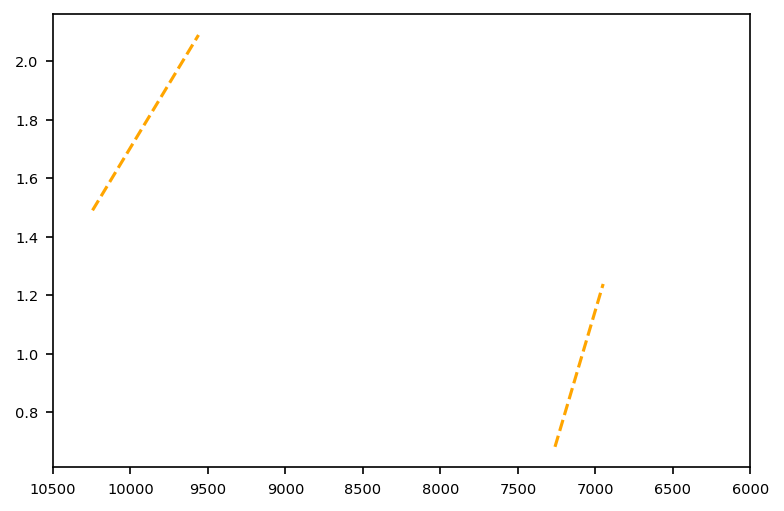

In [17]:
# Roap instability
x1=np.array([4.0105,3.9805])
y1=(1.5-1.7)*(x1-4.0)/(4.01-4.0)+1.7
x2=np.array([3.861, 3.842])
y2=(1.15-0.71)*(x2-3.86)/(3.845-3.86)+0.71

plt.plot(10**x1,y1, c='orange', linestyle='dashed', zorder=100)
plt.plot(10**x2, y2, c='orange', linestyle='dashed', zorder=100)
plt.xlim(10500,6000)

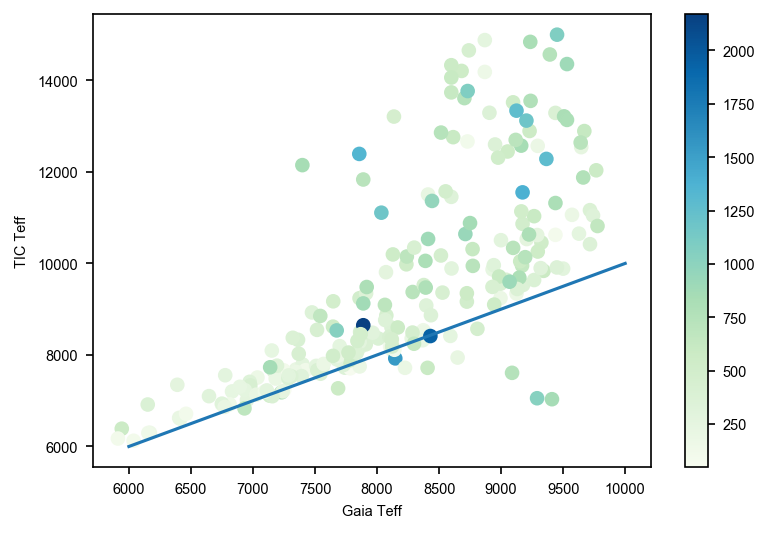

In [253]:
plt.scatter(df['teff_val'], df['teff'], c=(df['r_est']), cmap='GnBu')
plt.plot([6000,10000], [6000,10000])
plt.xlabel('Gaia Teff')
plt.ylabel('TIC Teff')
plt.colorbar()
# plt.savefig('Teff compare.png', bbox_inches='tight')

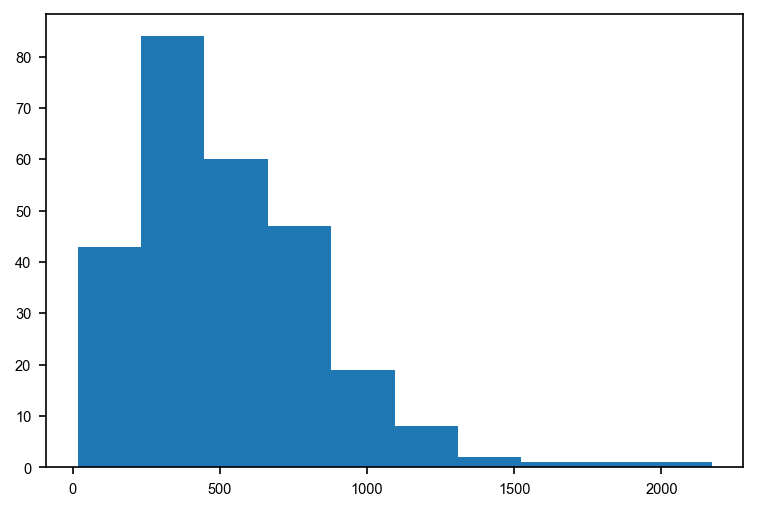

In [245]:
plt.hist(df['r_est']);

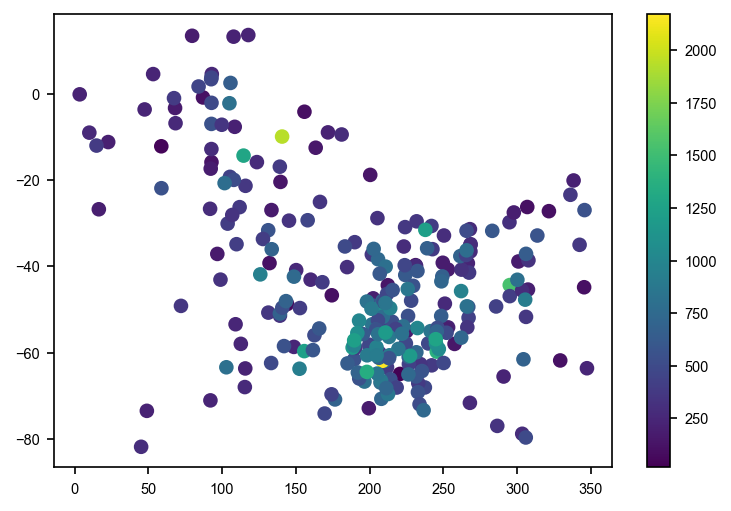

In [249]:
plt.scatter(df['ra'], df['dec'], c=df['r_est'])
plt.colorbar()

In [ ]:
from astroquery.gaia import Gaia
from tqdm import tqdm
import scipy.integrate as integrate
from scipy.stats import norm
from astropy.coordinates import SkyCoord
from dustmaps.bayestar import BayestarWebQuery
import h5py
from scipy.interpolate import RegularGridInterpolator
import astropy.units as units
​
bayestar = BayestarWebQuery()
​
# https://www.dropbox.com/s/921jc0ojlz6c6ar/bcgrid.h5?dl=0
bcmodel = h5py.File('/Users/danielhey/Downloads/bcgrid.h5', 'r')
interp = RegularGridInterpolator((np.array(bcmodel['teffgrid']), \
        np.array(bcmodel['logggrid']),np.array(bcmodel['fehgrid']), \
            np.array(bcmodel['avgrid'])),np.array(bcmodel['bc_gs'])) 
​
def ud_distpost3(r,w,wsd,rlen):
    ud = d_like(w, r, wsd)*np.exp(-r/rlen)*(r**2)
    return ud
​
# Normalized Gaussian likelihood in w. Vectorized in any one parameter.
def d_like(w,r,wsd):
    return norm.pdf(w, 1/r, wsd)
​
def Mv_mag(m_V, distance):
    return (m_V-5*(np.log10(distance)-1))
​
def getbc(teff,logg,feh,av):
    return interp(np.array([teff,logg,feh,av]))[0]
​
def log_L_bol(mag, distance, extinction, BC):
    return (-((mag - 5*(np.log10(distance)-1) - extinction) + BC - 4.74)/2.5)
​
def get_luminosity(g_magnitude, source_id, teff, feh, logg, iterations=200000):
    job = Gaia.launch_job("""
            SELECT  gaia.parallax, gaia.parallax_error, gaia.ra, gaia.dec, dist.r_len, dist.r_est
            FROM    gaiadr2.gaia_source AS gaia, external.gaiadr2_geometric_distance as dist
            WHERE   gaia.source_id = {}
                AND dist.source_id = {}
            """.format(source_id, source_id))
    sample = job.get_results()
    N = iterations
        
    # DISTANCE CALCULATION
    w = (sample['parallax'].data[0])*0.001
    wsd = (sample['parallax_error'].data[0])*0.001
    rlen = sample['r_len'].data[0]
    r_est = sample['r_est'].data[0]
    
    if r_est < 1000:
        scale = 0.01
    else:
        scale = 10
​
    rlo, rhi = r_est-scale*rlen, r_est+scale*rlen
    if rlo < 0:
        rlo = 1e-10
    rplot = np.linspace(rlo,rhi,N)
    dprior = (1/(2*rlen**3))*np.exp(-rplot/rlen)*rplot**2
    dpost  = ud_distpost3(rplot, w, wsd, rlen)
​
    integ = integrate.quad(ud_distpost3, rlo, rhi, args=(w,wsd,rlen))
    dpost_norm = dpost/integ[0]
​
    rlo, rhi = rplot[dpost_norm > 1e-20][0], rplot[dpost_norm > 1e-20][-1]
    rplot = np.linspace(rlo,rhi,N)
    dprior = (1/(2*rlen**3))*np.exp(-rplot/rlen)*rplot**2
    dpost  = ud_distpost3(rplot, w, wsd, rlen)
    integ = integrate.quad(ud_distpost3, rlo, rhi, args=(w,wsd,rlen))
    dpost_norm = dpost/integ[0]
    distance = rplot[np.argmax(dpost_norm)]
    
    # EXTINCTION
    ra = sample['ra'].data[0]
    dec = sample['dec'].data[0]
    d = distance
​
    coords = SkyCoord(ra=ra*units.deg, dec=dec*units.deg,
                          distance=d*units.pc)
    
    
    # see http://argonaut.skymaps.info/usage under "Gray Component". this is a lower limit.
    # lower bound for the gray offset 
    offset=0.063
    bstar = bayestar(coords, mode='median')
    percentiles = bayestar(coords, mode='percentile', pct=[84.13, 15.86])
    percentile_lower = percentiles[0]-bstar
    percentile_upper = bstar - percentiles[1]
    sigma = 0.5*(percentile_upper+percentile_lower)
    
    # This converts to g-band magnitude
    extinction_coefficient = 3.613
    extinction = (extinction_coefficient+offset) * bstar
    extinction_error = (extinction_coefficient+offset) * sigma
    
    # BOLOMETRICS
    bc = getbc(teff, logg, feh, 0)
    
    # LUMINOSITY  
    values = dpost_norm
    arr2 = (values - values.min()) / (values.max() - values.min())
    arr2 /= arr2.sum()
    
    distance_norm = np.random.choice(rplot,size=N, p=arr2)
    mag_norm = np.random.normal(g_magnitude, 0.02, N)
    BC_norm = np.random.normal(bc, 0.034, N)
    ag_norm = np.random.normal(extinction, extinction_error, N)
​
    val = log_L_bol(mag_norm, distance_norm, ag_norm, BC_norm)
    
    return np.mean(val), np.median(val), np.percentile(val,84.13), np.percentile(val,15.86), np.std(val)